In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [2]:
from elitho.mask_pattern import LinePattern
from elitho import const
from elitho import fourier

mask = LinePattern(cd=56, gap=80, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

/home/moshida/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
type(mask)

numpy.ndarray

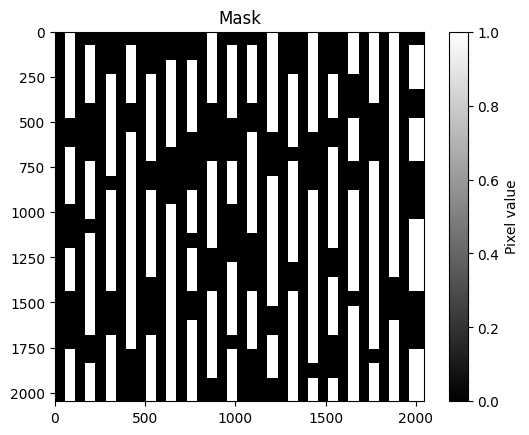

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [27]:
# %%timeit -n 10
# cpu ver
ampta = 0.95 + 0.0j
ampvc = 1.0 + 0.0j
famp = fourier.mask(mask, ampta, ampvc)

In [31]:
from elitho import descriptors, diffraction_order
dod = descriptors.DiffractionOrderDescriptor(6.0)

In [32]:
# %%timeit -n 10
# cpu ver
a, _, _, _ = fourier.coefficients(mask, const.absorption_amplitudes, dod)

In [33]:
a.dtype

dtype('complex128')

/tmp/ipykernel_3997427/1433951773.py:2: RuntimeWarning: divide by zero encountered in log
  famp = np.maximum(np.log(np.abs(famp)) + 10, 0)


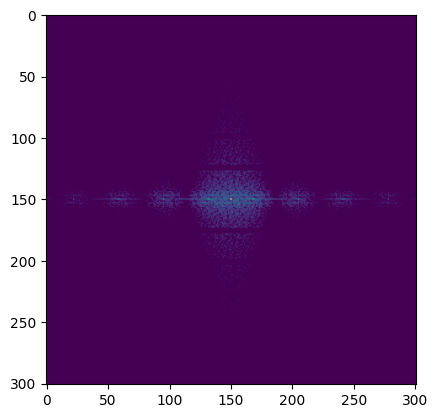

In [29]:
import numpy as np
famp = np.maximum(np.log(np.abs(famp)) + 10, 0)
plt.imshow(famp)
plt.show()

In [16]:
def test_np_ver(pattern_mask: np.ndarray, ampta: complex, ampvc: complex): 
    meshX = const.FDIVX // const.NDIVX
    meshY = const.FDIVY // const.NDIVY

    pattern = np.where(
        np.kron(pattern_mask, np.ones((meshX, meshY))), ampta, ampvc
    ).astype(
        np.complex128
    )  # shape: (FDIVX, FDIVY)

    famp_full = np.fft.fftshift(np.fft.fft2(pattern)) / (const.FDIVX * const.FDIVY)

    # === 3. 周波数中心付近の領域を切り出す ===
    cx = const.FDIVX // 2
    cy = const.FDIVY // 2
    half_L = const.Lrange2 // 2
    half_M = const.Mrange2 // 2

    famp = famp_full[
        cx - half_L : cx + half_L + (const.Lrange2 % 2),
        cy - half_M : cy + half_M + (const.Mrange2 % 2)
    ]
    
    return famp

In [17]:
own_famp = test_np_ver(mask, ampta, ampvc)
own_rfamp = np.maximum(np.log(np.abs(own_famp)) + 10, 0)

/tmp/ipykernel_3997427/3198047890.py:2: RuntimeWarning: divide by zero encountered in log
  own_rfamp = np.maximum(np.log(np.abs(own_famp)) + 10, 0)


In [18]:
own_rfamp.shape

(301, 301)

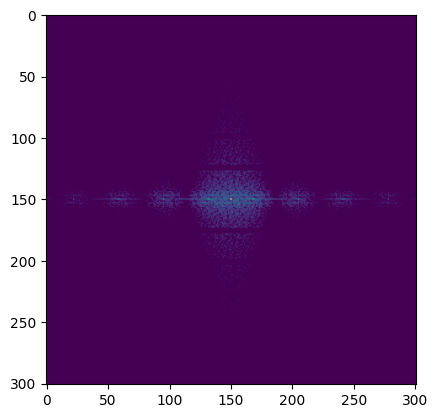

In [19]:
plt.imshow(own_rfamp)
plt.show()

In [30]:
np.allclose(famp, own_rfamp, atol=1e-6, rtol=1e-4)

True

In [4]:
import numpy as np

pattern = np.load("assets/params/pattern.npy", allow_pickle=True)
np.all(pattern == np.ones_like(pattern, dtype=np.complex128))

np.True_

In [5]:
pattern

array([[1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       ...,
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]],
      shape=(2048, 2048), dtype=complex256)

In [11]:
# fft_ptn = np.fft.fft2(pattern)
fft_ptn = np.fft.fft2(pattern, norm="forward")
fft_ptn

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      shape=(2048, 2048), dtype=complex256)

In [8]:
fft_ptn.min(), fft_ptn.max()

(np.clongdouble('0j'), np.clongdouble('1+0j'))

In [9]:
shifted_fft_ptn = np.fft.fftshift(fft_ptn)
shifted_fft_ptn.min(), shifted_fft_ptn.max()

(np.clongdouble('0j'), np.clongdouble('1+0j'))

In [69]:
w, h = pattern.shape
scaled_shifted_fft_ptn = shifted_fft_ptn / (w * h)
scaled_shifted_fft_ptn.min(), scaled_shifted_fft_ptn.max()

(np.clongdouble('0j'), np.clongdouble('1+0j'))

In [ ]:
np.where(scaled_shifted_fft_ptn == 1) # 中心のみ1

(array([1024]), array([1024]))

In [57]:
fft_map = np.load("fft_map.npy", allow_pickle=True)
fft_map, fft_map.min()

(array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
       shape=(2048, 2048), dtype=complex256),
 np.clongdouble('0j'))

In [58]:
norm_fft_map = np.load("norm_fft_map.npy", allow_pickle=True)
norm_fft_map, norm_fft_map.min()

(array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
       shape=(2048, 2048), dtype=complex256),
 np.clongdouble('0j'))

In [38]:
a = 1.579864e-33+4.513898e-35j
a

(1.579864e-33+4.513898e-35j)

In [48]:
import numpy as np
# np.set_printoptions(precision=256, suppress=False)
epsN = np.load("epsN.npy", allow_pickle=True)

In [49]:
epsN, epsN.dtype

(array([[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]],
       shape=(1, 301, 301)),
 dtype('complex128'))

In [36]:
epsN.min()

np.complex128(0j)

In [20]:
diff_idx = epsN != np.zeros_like(epsN, dtype=np.complex128)
epsN[diff_idx]

array([1.+0.j])

array([[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]],
      shape=(1, 301, 301), dtype=complex64)